# Simulating the Deutsch–Jozsa algorithm at the pulse level

Author: Boxi Li (etamin1201@gmail.com)

In this example, we demonstrate how to simulate simple quantum algorithms on a qauntum hardware with QuTiP. The simulators are defined in the class `Processor`(and its sub-classes). `Processor` represents a general quantum device. The interaction of the quantum systems such as qubits is defined by the control Hamiltonian. For a general introduction of pulse-level simulation, please refer to [the user guide](https://qutip-qip.readthedocs.io/en/stable/qip-processor.html).

In the following, we compile a simple three-qubit quantum circuit into control pulses on different Hamiltonian model.

## The Deutsch–Jozsa algorithm
The Deutsch–Jozsa algorithm is the simplest quantum algorithm that offers an exponential speed-up compared to the classical one. It assumes that we have a function $f:\{0,1\}^n \rightarrow \{0,1\}$ which is either balanced or constant. Constant means that $f(x)$ is either 1 or 0 for all inputs while balanced means that $f(x)$ is 1 for half of the input domain and 0 for the other half. A more rigorous definition can be found at https://en.wikipedia.org/wiki/Deutsch-Jozsa_algorithm.

The implementation of the Deutsch–Jozsa algorithm includes $n$ input qubits and 1 ancilla initialised in state $1$. At the end of the algorithm, the first $n$ qubits are measured on the computational basis. If the function is constant, the result will be $0$ for all $n$ qubits. If balanced, $\left|00...0\right\rangle$ will never be measured.
The following example is implemented for the balanced function $f:\{00,01,10,11\} \rightarrow \{0,1\}$, where $f(00)=f(11)=0$ and $f(01)=f(10)=1$. This function is balanced, so the probability of measuring state $\left|00\right\rangle$ should be 0.

In [1]:
import numpy as np
from qutip import basis, ptrace
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import (LinearSpinChain, OptPulseProcessor, SCQubits,
                              SpinChainModel)
from qutip.ipynbtools import version_table
import qutip_qip

In [2]:
qc = QubitCircuit(N=3)
qc.add_gate("X", targets=2)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# function f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

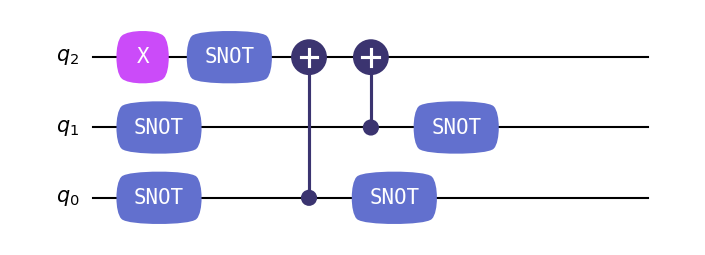

In [3]:
qc

## Using the spin chain model
First, we simulate the quantum circuit using the Hamiltonian model `LinearSpinChain`. The control Hamiltonians are defined in [`SpinChainModel`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.device.html#qutip_qip.device.SpinChainModel).

In [4]:
processor = LinearSpinChain(3)
processor.load_circuit(qc);

To quickly visualize the pulse, `Processor` has a method called `plot_pulses`. In the figure bellow, each colour represents the pulse sequence of one control Hamiltonian in the system as a function of time. In each time interval, the pulse remains constant.

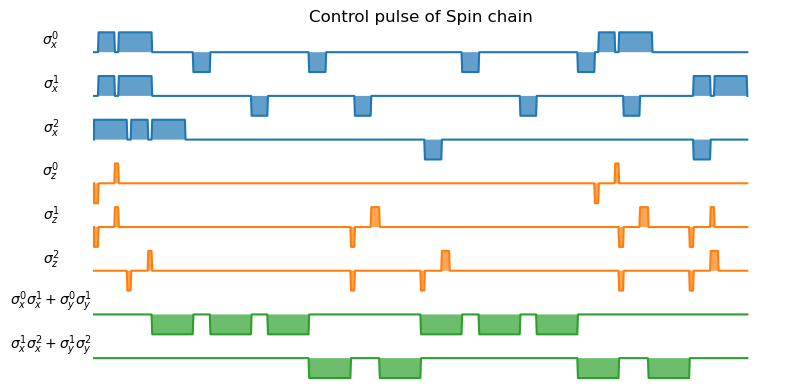

In [5]:
processor.plot_pulses(title="Control pulse of Spin chain",
                      figsize=(8, 4), dpi=100);

Because for the spin chain model interaction only exists between neighbouring qubits, SWAP gates are added between and after the first CNOT gate, swapping the first two qubits. The SWAP gate is decomposed into three iSWAP gates, while the CNOT is decomposed into two iSWAP gates plus additional single-qubit corrections. Both the Hadamard gate and the two-qubit gates need to be decomposed to native gates (iSWAP and rotation on the $x$ and $z$ axes). The compiled coefficients are square pulses and the control coefficients on $\sigma_z$ and $\sigma_x$ are also different, resulting in different gate times.

### Without decoherence

In [6]:
basis00 = basis([2, 2], [0, 0])
psi0 = basis([2, 2, 2], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[1.54116069e-08]]


### With decoherence

In [7]:
processor.t1 = 100
processor.t2 = 30
psi0 = basis([2, 2, 2], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[0.13730233]]


## Using the optimal control module
This feature integrated into the sub-class `OptPulseProcessor` which use methods in the optimal control module to find the optimal pulse sequence for the desired gates. It can find the optimal pulse either for the whole unitary evolution or for each gate. Here we choose the second option.

In [8]:
setting_args = {
    "SNOT": {"num_tslots": 6, "evo_time": 2},
    "X": {"num_tslots": 1, "evo_time": 0.5},
    "CNOT": {"num_tslots": 12, "evo_time": 5},
}
# Use the control Hamiltonians of the spin chain model.
processor = OptPulseProcessor(
    num_qubits=3, model=SpinChainModel(3, setup="linear")
)
processor.load_circuit(  # Provide parameters for the algorithm
    qc,
    setting_args=setting_args,
    merge_gates=False,
    verbose=True,
    amp_ubound=5,
    amp_lbound=0,
);

********** Gate 0 **********
Final fidelity error 0.2199398612133493
Final gradient normal 3.1065688536158395e-05
Terminated due to function converged
Number of iterations 29


********** Gate 1 **********
Final fidelity error 0.019495589746968967
Final gradient normal 0.034390722282436836
Terminated due to Iteration or fidelity function call limit reached
Number of iterations 500


********** Gate 2 **********
Final fidelity error 0.04337451890506372
Final gradient normal 0.09698634522003677
Terminated due to function converged
Number of iterations 268


********** Gate 3 **********
Final fidelity error 0.015732141571964564
Final gradient normal 0.023695417910821186
Terminated due to function converged
Number of iterations 197


********** Gate 4 **********
Final fidelity error 1.010354866437524e-08
Final gradient normal 0.0002830382119541253
Terminated due to function converged
Number of iterations 103


********** Gate 5 **********
Final fidelity error 1.5457129243223733e-08
Final gradient normal 0.0004900165552391689
Terminated due to function converged
Number of iterations 115


********** Gate 6 **********
Final fidelity error 0.01017554811096777
Final gradient normal 0.04460748065775428
Terminated due to Iteration or fidelity function call limit reached
Number of iterations 500


********** Gate 7 **********
Final fidelity error 0.005174490282539579
Final gradient normal 0.023095746849599558
Terminated due to function converged
Number of iterations 417


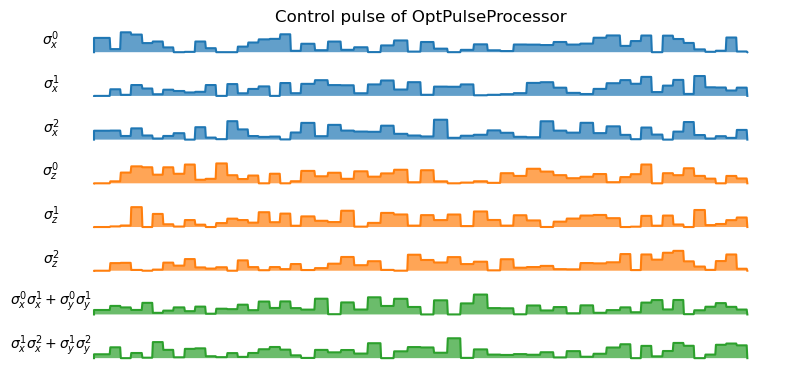

In [9]:
processor.plot_pulses(
    title="Control pulse of OptPulseProcessor", figsize=(8, 4), dpi=100
);

For the optimal control model, we use the GRAPE algorithm, where control pulses are piece-wise constant functions. We provide the algorithm with the same control Hamiltonian model used for the spin chain model. In the compiled optimal signals, all controls are active (non-zero pulse amplitude) during most of the execution time. We note that for identical gates on different qubits (e.g., Hadamard), each optimized pulse is different, demonstrating that the optimized solution is not unique, and there are further constraints one could apply, such as adaptions for the specific hardware.

### Without decoherence

In [10]:
basis00 = basis([2, 2], [0, 0])
psi0 = basis([2, 2, 2], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[0.14545448]]


### With decoherence

In [11]:
processor.t1 = 100
processor.t2 = 30
psi0 = basis([2, 2, 2], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[0.21846798]]


We can see that under noisy evolution their is a none zero probability of measuring state 00.

## Using the superconducting qubits model
Below, we simulate the same quantum circuit using one sub-class `LinearSpinChain`. It will find the pulse based on the Hamiltonian available on a quantum computer of the linear spin chain system.
Please refer to [the notebook of the spin chain model](../time-evolution/005_spin-chain.md) for more details.

In [12]:
processor = SCQubits(num_qubits=3)
processor.load_circuit(qc);

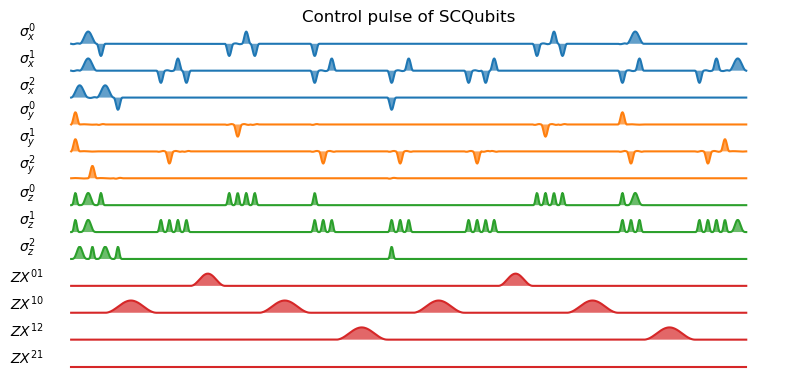

In [13]:
processor.plot_pulses(title="Control pulse of SCQubits",
                      figsize=(8, 4), dpi=100);

For the superconducting-qubit processor, the compiled pulses have a Gaussian shape. This is crucial for superconducting qubits because the second excited level is only slightly detuned from the qubit transition energy. A smooth pulse usually prevents leakage to the non-computational subspace. Similar to the spin chain, SWAP gates are added to switch the zeroth and first qubit and one SWAP gate is compiled to three CNOT gates. The control $ZX^{21}$ is not used because there is no CNOT gate that is controlled by the second qubit and acts on the first one.

### Without decoherence

In [14]:
basis00 = basis([3, 3], [0, 0])
psi0 = basis([3, 3, 3], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[8.07454589e-08]]


### With decoherence

In [15]:
processor.t1 = 50.0e3
processor.t2 = 20.0e3
psi0 = basis([3, 3, 3], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0, 1]) * basis00)))

Probability of measuring state 00:
[[0.07238427]]


In [16]:
print("qutip-qip version:", qutip_qip.version.version)
version_table()

qutip-qip version: 0.5.0.dev0+d58a82d


Software,Version
QuTiP,4.7.6
Numpy,1.26.4
SciPy,1.12.0
matplotlib,3.5.2
Cython,0.29.37
Number of CPUs,4
BLAS Info,Generic
IPython,8.35.0
Python,"3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:39:04) [GCC 10.3.0]"
OS,posix [linux]
